# SMCN application for air quality predictions

In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from oze.utils import plot_predictions
from oze.dataset import OzeDataset
from src.metrics import compute_cost, cumulative_cost
from src.utils import plot_range, uncertainty_estimation, LitProgressBar, boxplotprediction

# Set manual seeds
torch.manual_seed(1)

# Reload python packages when changed
%load_ext autoreload
%autoreload 2

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (25, 5)
})

# PyTorch Lightning loading bar
bar = LitProgressBar()

In [2]:
# Dataset
PATH_DATASET = "datasets/data_2020_2021.csv"
T = 24*7

# Model
D_EMB = 8
N = 200

# Training
BATCH_SIZE = 4
EPOCHS = 100
EPOCHS_SMCN = 100

## Dataset

### Load and preprocess

In [3]:
df = pd.read_csv(PATH_DATASET)[5*24:]
OzeDataset.preprocess(df)
D_IN = len(OzeDataset.input_columns)
D_OUT = len(OzeDataset.target_columns)
df.sample(5)

/home/mrmojo/Code/these/smcl/oze/utils.py:69: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  occupancy = int(date < date_start_lockdown)
/home/mrmojo/Code/these/smcl/oze/utils.py:72: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_end_lockdown < date:


,IBEAM_H,IBEAM_N,IDIFF_H,GK,RHUM,IGLOB_H,temperature_exterieure,temperature_interieure,taux_co2,humidite,cta_temperature,electricite,date,datetime,occupancy,val
3837,0.0,0.0,9.0,8.0,56.0,9.0,14.3,21.506600,422.069828,43.273623,19.174889,195.30,1.591643e+09,2020-06-08 21:00:00,0.0,False
15208,50.0,105.0,207.0,287.0,54.0,257.0,19.6,21.588889,402.836565,66.072707,21.066427,148.68,1.632578e+09,2021-09-25 16:00:00,0.0,True
12189,0.0,0.0,0.0,0.0,75.0,1.0,14.8,20.875712,401.749420,36.512555,19.188610,136.44,1.621710e+09,2021-05-22 21:00:00,0.0,True
14849,56.0,129.0,191.0,270.0,54.0,246.0,22.0,23.566066,398.679222,49.490279,22.369573,150.84,1.631286e+09,2021-09-10 17:00:00,0.8,True
11296,0.0,0.0,135.0,124.0,68.0,135.0,10.2,20.007961,459.866371,22.798178,18.181029,201.42,1.618495e+09,2021-04-15 16:00:00,0.8,True


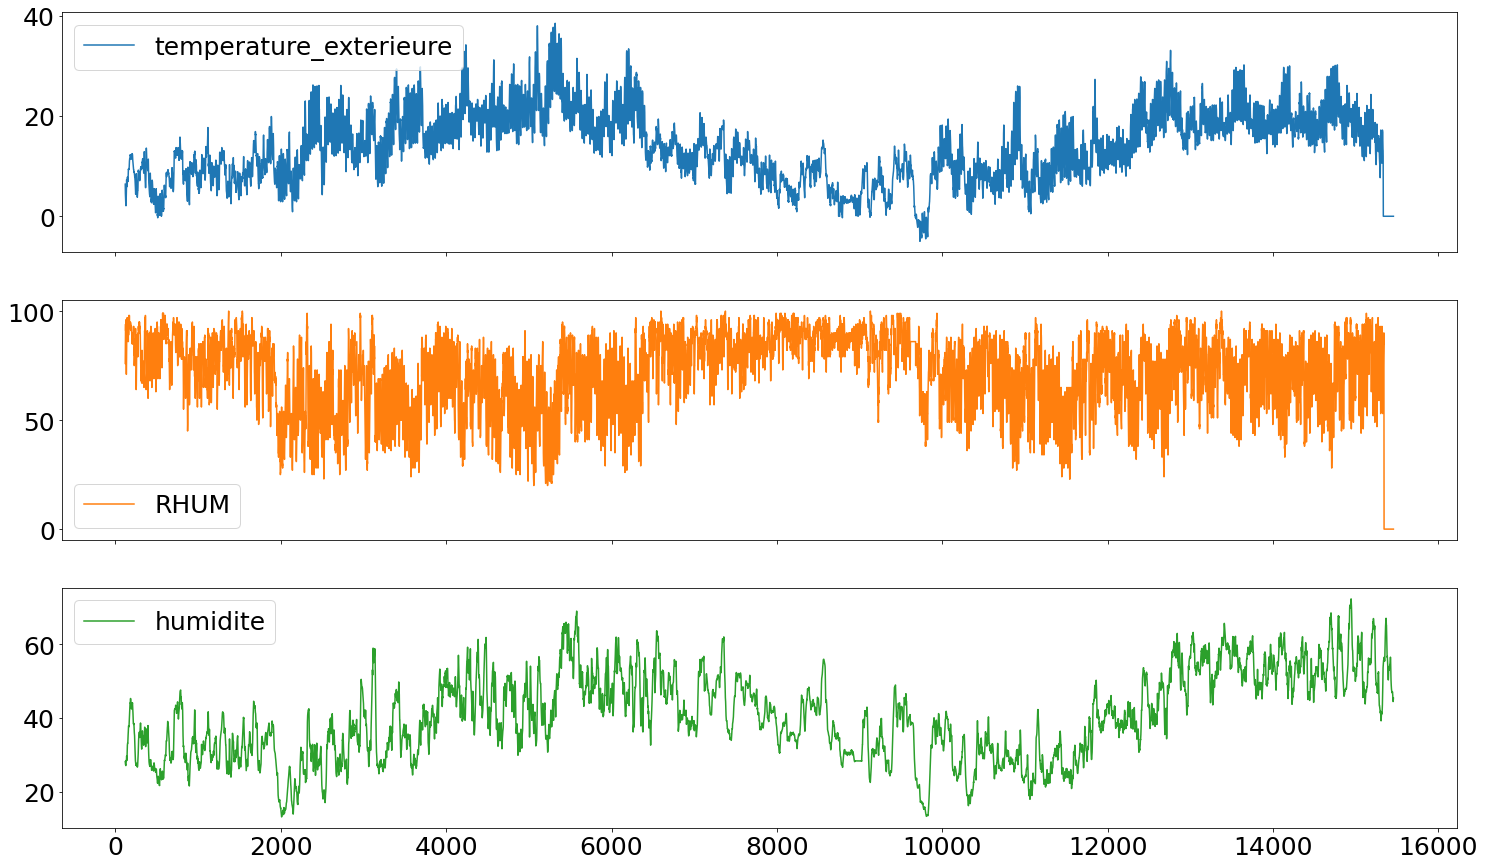

In [4]:
_ = df[[*OzeDataset.input_columns, *OzeDataset.target_columns]].plot(subplots=True, figsize=(25, 5*(len(OzeDataset.input_columns + OzeDataset.target_columns))))

### Define dataloaders

In [5]:
dataloader_train = DataLoader(
    OzeDataset(df, T=T, val=False),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

dataloader_val = DataLoader(
    OzeDataset(df, T=T, val=True),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

## Model

In [6]:
class LSTM_dropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super().__init__()
        
        self.input_model = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=3, dropout=dropout)
        self.output_model = nn.Linear(in_features=hidden_size,
                         out_features=output_size)
        
    def forward(self, u):
        u_tilde = self.input_model(u)[0]
        y_hat = self.output_model(u_tilde)
        return y_hat
    
    def uncertainty_estimation(self, u, y, N=100):
        self.train()
        T, BS, _ = u.shape
        input_tensor = u.repeat_interleave(repeats=N, dim=1)
        return self(input_tensor).reshape(T, BS, N, -1)
model = LSTM_dropout(input_size=D_IN, hidden_size=D_EMB, output_size=D_OUT)

## Traditional training

### Define training steps

In [7]:
class LitClassicModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criteria = torch.nn.MSELoss()
        self.hist = []
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)

        y_hat = self.model(u)
        loss = self.criteria(y, y_hat)
        self.hist.append(loss.item())
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer

### Train

In [8]:
train_model = LitClassicModule(model, lr=1e-2)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Save pretrain parameters
params_pretrain = copy.deepcopy(model.state_dict())

# Compute cost (default to MSE) mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Epoch: 1/100:   0%|                                                                                                                                                    | 0/100 [00:00<?, ?it/s]
  | Name     | Type         | Params
------------------------------------------
0 | model    | LSTM_dropout | 1.2 K 
1 | criteria | MSELoss      | 0     
------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn

MSE:	0.38 \pm 1.8364


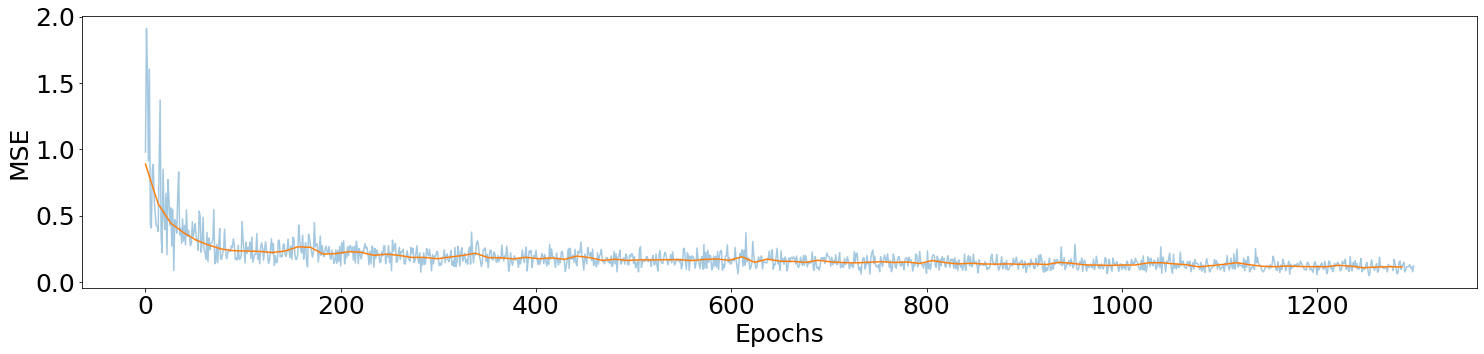

In [9]:
loss = np.array(train_model.hist)
plt.plot(loss, alpha=.4)
plt.plot(np.arange(0, len(loss), len(dataloader_train)), loss.reshape(EPOCHS, len(dataloader_train)).mean(-1))
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

### Plot predictions

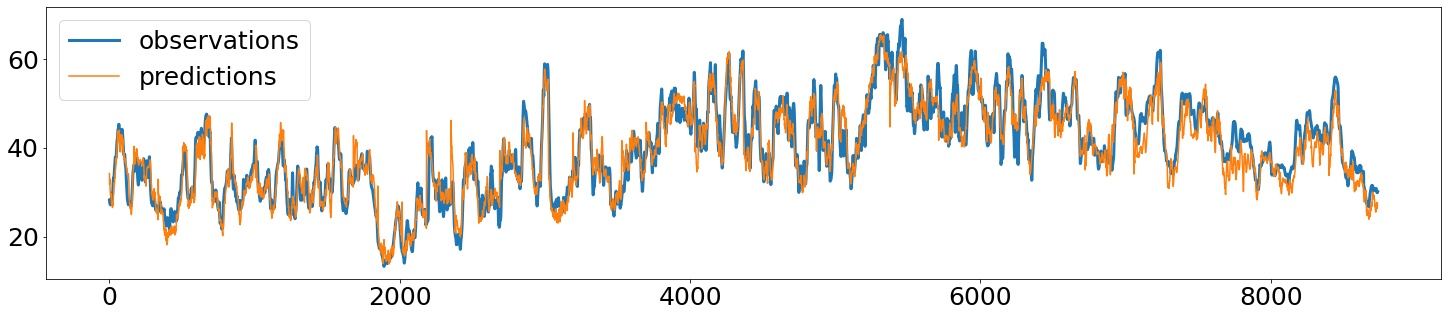

In [10]:
plot_predictions(model, dataloader_train.dataset)

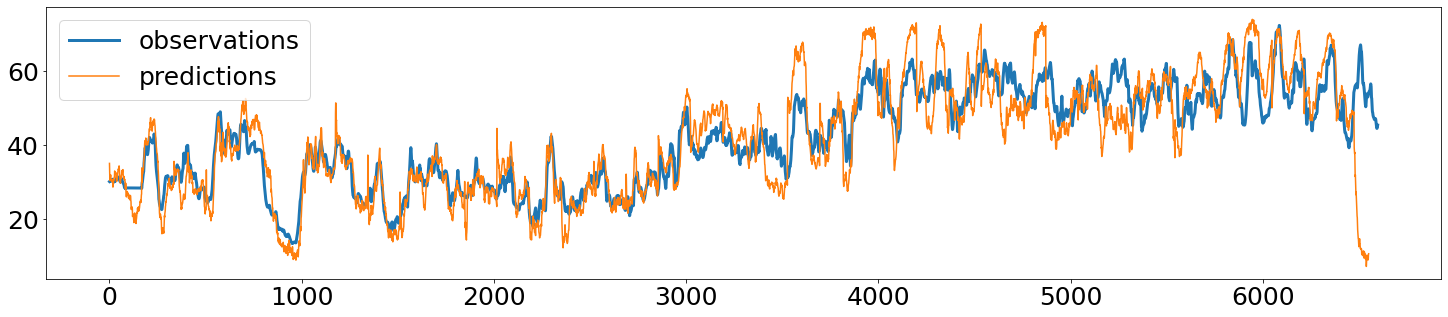

In [11]:
plot_predictions(model, dataloader_val.dataset)

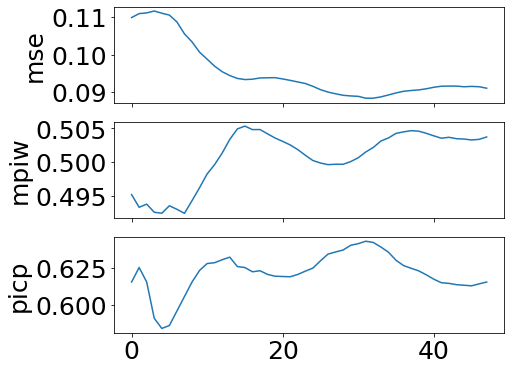

In [12]:
criterias = {
    "mse": model,
    "mpiw": model.uncertainty_estimation,
    "picp": model.uncertainty_estimation,
}

_, axes = plt.subplots(len(criterias), 1, sharex=True, squeeze=False, figsize=(7, 2*len(criterias)))

for (criteria, criteria_model), ax in zip(criterias.items(), axes[:, 0]):
    ax.plot(cumulative_cost(criteria_model, dataloader_train, criteria=criteria, reduction="mean"))
    ax.set_ylabel(criteria)

### Train

In [ ]:
# Train model
train_model = LitSMCModule(model, lr=3e-3)
trainer = pl.Trainer(max_epochs=EPOCHS_SMCN, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Compute MSE mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

# Compute PI metrics
picp, mpiw = pi_metrics(model.uncertainty_estimation, dataloader_val)
print(f"PICP:\t{picp.mean():.2f} \pm {picp.var():.4f}\nMPIW:\t{mpiw.mean():.3f} \pm {mpiw.var():.4f}")

### Evaluate predictions

In [ ]:
# Generate inference sample
idx = np.random.randint(0, len(dataloader_val.dataset))
u, y = dataloader_val.dataset[idx]
u = u.unsqueeze(1)
y = y.unsqueeze(1)

# Set target idx for vialization (0 for CO2 levels)
idx_out = 0

#### Traditional inference with new weights

In [ ]:
# Plot inference with original model, print cost
model.N=1
plot_daily_predictions(model, dataloader_val)
losses = compute_cost(model, dataloader_val, criteria=torch.nn.L1Loss(reduction='none'))
print(f"{losses.mean():.2f} \pm {losses.var():.4f}")
model.N=N

#### Smoother predictions

In [ ]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I).numpy()

plot_range(netout[:, 0, :, idx_out], label='predictions')
plt.plot(y[:, 0, idx_out], lw=3, label='observations')
plt.legend()
plt.show()

#### Predictions at $t+1$

In [ ]:
start_day = 0
end_day = start_day+7
day_hide = 0
tick_step = 12
burnin = 0
netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=burnin)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]

plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100, color="#2ca02c")

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

In [ ]:
start_day = 3
end_day = start_day+3
day_hide = start_day+1
tick_step = 12

netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=0)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]


plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100)

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

#### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

In [ ]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I)

batch_idx = 0

netout = netout[:, batch_idx, :, idx_out].numpy()
w = model.smcl.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')